In [1]:
# inport the necessary library

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import torch.nn.functional as F

Load the MNIST Datasets

In [4]:
train_dataset=torchvision.datasets.MNIST(root='./data',train=True,transform=torchvision.transforms.ToTensor(),download=True)

In [5]:
test_dataset=torchvision.datasets.MNIST(root='./data',train=False,transform=torchvision.transforms.ToTensor(),download=True)

Make model

In [7]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(1,32,kernel_size=3,padding=1)
        self.conv2=nn.Conv2d(32,64,kernel_size=3,padding=1)
        self.pool=nn.MaxPool2d(2,2)
        self.dropout1=nn.Dropout2d(0.25)
        self.dropout2=nn.Dropout2d(0.5)
        self.fc1=nn.Linear(64*7*7,128)
        self.fc2=nn.Linear(128,10)
        
    def forward(self,x):
        x=self.pool(F.relu(self.conv1(x)))
        x=self.dropout1(x)
        x=self.pool(F.relu(self.conv2(x)))
        x=self.dropout2(x)
        x=x.view(-1,64*7*7)
        x=F.relu(self.fc1(x))
        x=self.fc2(x)
        return x

In [29]:
num_of_gpus = torch.cuda.device_count()
print(num_of_gpus)

0


In [8]:
# gpu vs cpu
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [9]:
model=Classifier()
model.to(device)
summary(model,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
         Dropout2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
         MaxPool2d-5             [-1, 64, 7, 7]               0
         Dropout2d-6             [-1, 64, 7, 7]               0
            Linear-7                  [-1, 128]         401,536
            Linear-8                   [-1, 10]           1,290
Total params: 421,642
Trainable params: 421,642
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.43
Params size (MB): 1.61
Estimated Total Size (MB): 2.04
----------------------------------------------------------------


In [11]:
# define the loss function and optimizer

criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)

 Train the model

In [15]:
batch_size=100
num_epochs=10
val_percent=0.2
val_size=int(val_percent*len(train_dataset))
train_size=len(train_dataset)-val_size

train_dataset,val_dataset=torch.utils.data.random_split(train_dataset,[train_size,val_size])

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=batch_size,shuffle=True, pin_memory=True)  
                                         

# train the model 
losses=[]
accuracies=[]
val_losses=[]
val_accuracies=[]

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader): 
        # Forward pass 
        images=images.to(device) 
        labels=labels.to(device) 
        outputs = model(images) 
        loss = criterion(outputs, labels) 
          
        # Backward pass and optimization 
        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step() 
  
        _, predicted = torch.max(outputs.data, 1) 
    acc = (predicted == labels).sum().item() / labels.size(0) 
    accuracies.append(acc) 
    losses.append(loss.item())   
          
    # Evaluate the model on the validation set 
    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad(): 
        for images, labels in val_loader: 
            labels=labels.to(device) 
            images=images.to(device) 
            outputs = model(images) 
            loss = criterion(outputs, labels) 
            val_loss += loss.item() 
              
            _, predicted = torch.max(outputs.data, 1) 
        total = labels.size(0) 
        correct = (predicted == labels).sum().item() 
        val_acc += correct / total 
        val_accuracies.append(acc) 
        val_losses.append(loss.item())   

        
    print('Epoch [{}/{}],Loss:{:.4f},Validation Loss:{:.4f},Accuracy:{:.2f},Validation Accuracy:{:.2f}'.format( 
        epoch+1, num_epochs, loss.item(), val_loss, acc ,val_acc))   
    

Epoch [1/10],Loss:0.3438,Validation Loss:12.4340,Accuracy:0.93,Validation Accuracy:0.86
Epoch [2/10],Loss:0.0242,Validation Loss:8.3677,Accuracy:0.95,Validation Accuracy:1.00
Epoch [3/10],Loss:0.0699,Validation Loss:6.4317,Accuracy:0.99,Validation Accuracy:0.98
Epoch [4/10],Loss:0.0962,Validation Loss:5.4613,Accuracy:0.96,Validation Accuracy:0.98
Epoch [5/10],Loss:0.0572,Validation Loss:5.4523,Accuracy:1.00,Validation Accuracy:0.98
Epoch [6/10],Loss:0.0373,Validation Loss:5.2210,Accuracy:0.99,Validation Accuracy:0.98
Epoch [7/10],Loss:0.2346,Validation Loss:4.3192,Accuracy:1.00,Validation Accuracy:0.95
Epoch [8/10],Loss:0.0122,Validation Loss:4.7662,Accuracy:0.99,Validation Accuracy:1.00
Epoch [9/10],Loss:0.0326,Validation Loss:4.5137,Accuracy:1.00,Validation Accuracy:0.98
Epoch [10/10],Loss:0.2103,Validation Loss:4.6304,Accuracy:1.00,Validation Accuracy:0.95


check the validation curve to check overfitting and underfitting

In [16]:
import matplotlib.pyplot as plt

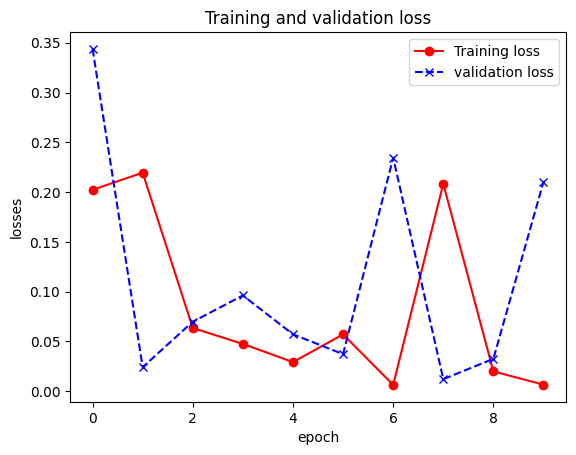

In [18]:
# plot the training and validation loss

plt.plot(range(num_epochs),losses,color='red',label='Training loss',marker='o')
plt.plot(range(num_epochs),val_losses,linestyle='--',color='blue',label='validation loss',marker='x')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('Training and validation loss')
plt.legend()
plt.show()

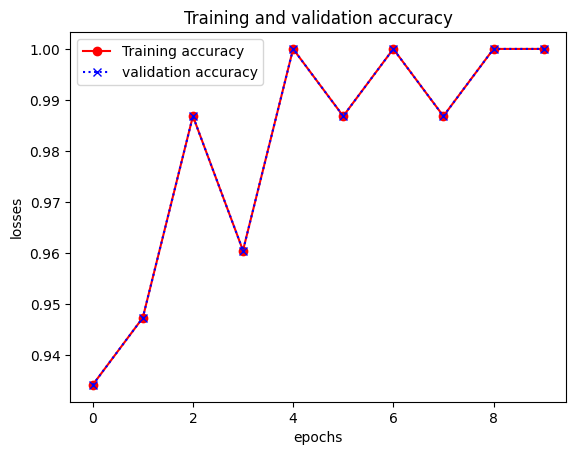

In [20]:
# plot the traing and validation accuracy

plt.plot(range(num_epochs),accuracies,color='red',label='Training accuracy',marker='o')
plt.plot(range(num_epochs),val_accuracies,linestyle=':',color='blue',label='validation accuracy',marker='x')
plt.xlabel('epochs')
plt.ylabel('losses')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

Evaluation

In [24]:
test_loader=torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

In [25]:
model.eval()
with torch.no_grad():
    correct=0
    total=0
    y_true=[]
    y_pred=[]
    for images, labels in test_loader:
        images=images.to(device)
        labels=labels.to(device)
        outputs=model(images)
        _,predicted=torch.max(outputs.data,1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()
        predicted=predicted.to('cpu')
        labels=labels.to('cpu')
        y_true.extend(labels)
        y_pred.extend(predicted)
        
    print('Test Accuracy {}%'.format(100*correct/total))   

Test Accuracy 98.92%


In [28]:
from sklearn.metrics import classification_report 
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.98      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       1.00      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.98      0.99       958
           7       0.99      0.98      0.99      1028
           8       0.98      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

